# CH. 9 - Hotspot Analysis
## Exercises

#### exercise 1: true density versus estimated density

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import mpl_toolkits.basemap
import numpy
import pandas
import scipy.stats
import seaborn
import sklearn.datasets
import sklearn.model_selection
import sklearn.neighbors

seaborn.set()

In [2]:
# generate x vector for plotting
# the range of the density being estimated

x_vec = numpy.linspace(-30, 30, 10000)[:, numpy.newaxis]

In [3]:
# generate random sample
# mixture of three normal distributions

vals = numpy.concatenate((
    numpy.random.normal(loc=1, scale=2.5, size=500), 
    numpy.random.normal(loc=10, scale=4, size=500), 
    numpy.random.normal(loc=-12, scale=5, size=500)
))[:, numpy.newaxis]

true_density = (
    (1 / 3) * scipy.stats.norm(1, 2.5).pdf(x_vec[:, 0]) + 
    (1 / 3) * scipy.stats.norm(10, 4).pdf(x_vec[:, 0]) +
    (1 / 3) * scipy.stats.norm(-12, 5).pdf(x_vec[:, 0])
)

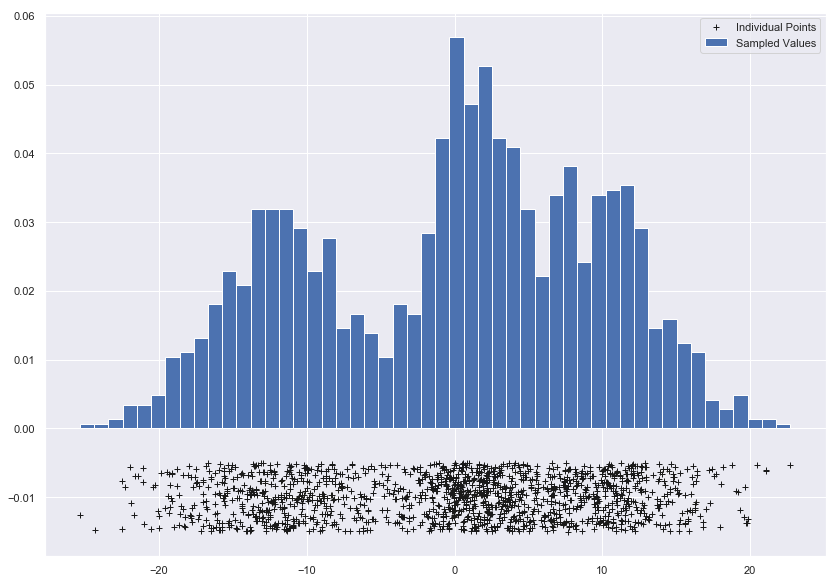

In [4]:
# plot random sample as histogram

fig, ax = plt.subplots(figsize=(14, 10))
ax.hist(vals, bins=50, density=True, label='Sampled Values')
ax.plot(
    vals[:, 0], 
    -0.005 - 0.01 * numpy.random.random(vals.shape[0]), 
    '+k', 
    label='Individual Points'
)
ax.legend(loc='upper right')

In [5]:
# run kernel density estimation

kde = sklearn.neighbors.KernelDensity(kernel='gaussian', bandwidth=1).fit(vals)
log_density = kde.score_samples(x_vec)

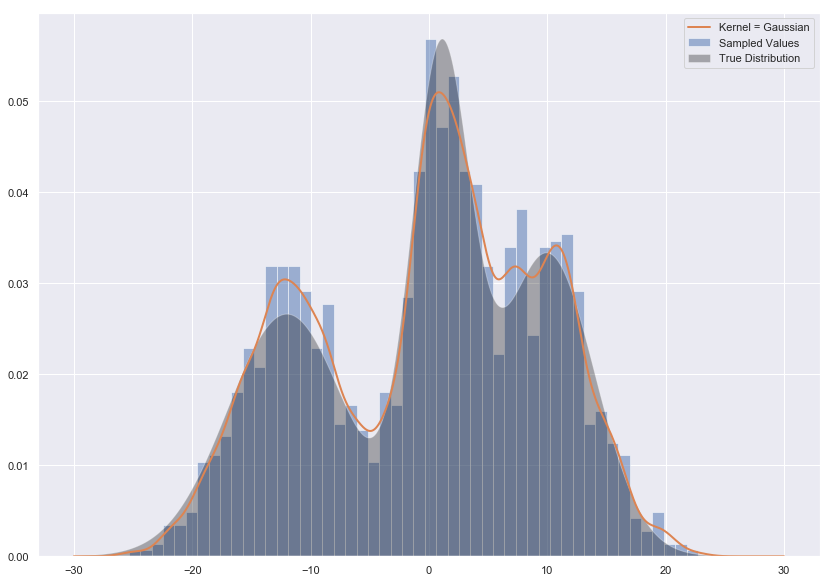

In [6]:
# plot histogram with two overlays
# 1. the true density that generated the data
# 2. the estimated density

fig, ax = plt.subplots(figsize=(14, 10))
ax.hist(vals, bins=50, density=True, alpha=0.5, label='Sampled Values')
ax.fill(x_vec[:, 0], true_density, fc='black', alpha=0.3, label='True Distribution')
ax.plot(x_vec[:, 0], numpy.exp(log_density), '-', linewidth=2, label='Kernel = Gaussian')
ax.legend(loc='upper right')

#### exercise 2: effect of bandwidth value

In [7]:
# for plotting:
# (row of plot, column of plot, bandwidth value)

position_bandwidth_vec = [
    (0, 0, 0.1), (0, 1, 0.4), (0, 2, 0.7), 
    (1, 0, 1.0), (1, 1, 1.3), (1, 2, 1.6), 
    (2, 0, 1.9), (2, 1, 2.5), (2, 2, 5.0)
]

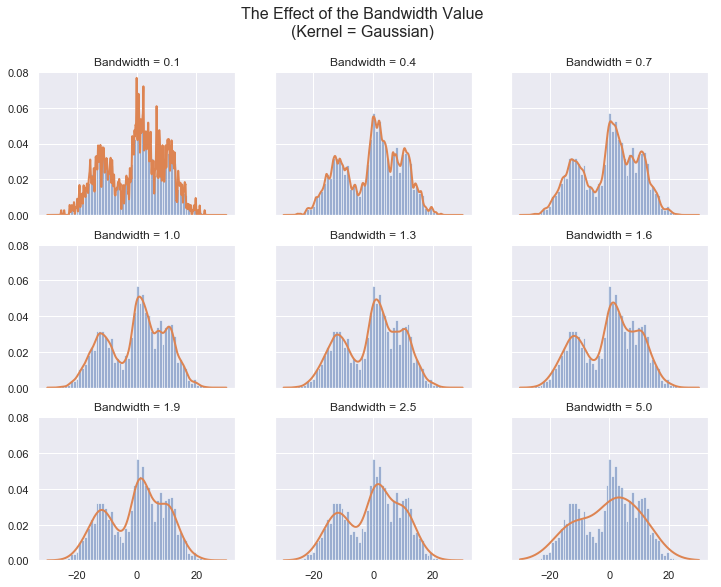

In [8]:
# effect of bandwidth value plot

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 9))
fig.suptitle('The Effect of the Bandwidth Value\n(Kernel = Gaussian)', fontsize=16)

for r, c, b in position_bandwidth_vec:
    kde = sklearn.neighbors.KernelDensity(kernel='gaussian', bandwidth=b).fit(vals)
    log_density = kde.score_samples(x_vec)

    ax[r, c].hist(vals, bins=50, density=True, alpha=0.5)
    ax[r, c].plot(x_vec[:, 0], numpy.exp(log_density), '-', linewidth=2)
    ax[r, c].set_title('Bandwidth = {}'.format(b))

#### exercise 3: select optimal bandwidth using grid search

In [9]:
# creating bandwidth vector
# to be used in grid search

bandwidths = 10 ** numpy.linspace(-1, 1, 100)

In [10]:
# maximize the score
# score = pseudo-log-likelihood

# for time do 10-fold cv instead of leave-one-out

grid = sklearn.model_selection.GridSearchCV(
    estimator=sklearn.neighbors.KernelDensity(kernel="gaussian"),
    param_grid={"bandwidth": bandwidths},
    cv=10 #sklearn.model_selection.LeaveOneOut().get_n_splits(vals)
)
grid.fit(vals)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'bandwidth': array([ 0.1    ,  0.10476, ...,  9.54548, 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [11]:
# optimal bandwidth value

best_bandwidth = grid.best_params_["bandwidth"]

print(
    "Best Bandwidth Value: {}"
    .format(best_bandwidth)
)

Best Bandwidth Value: 1.873817422860385


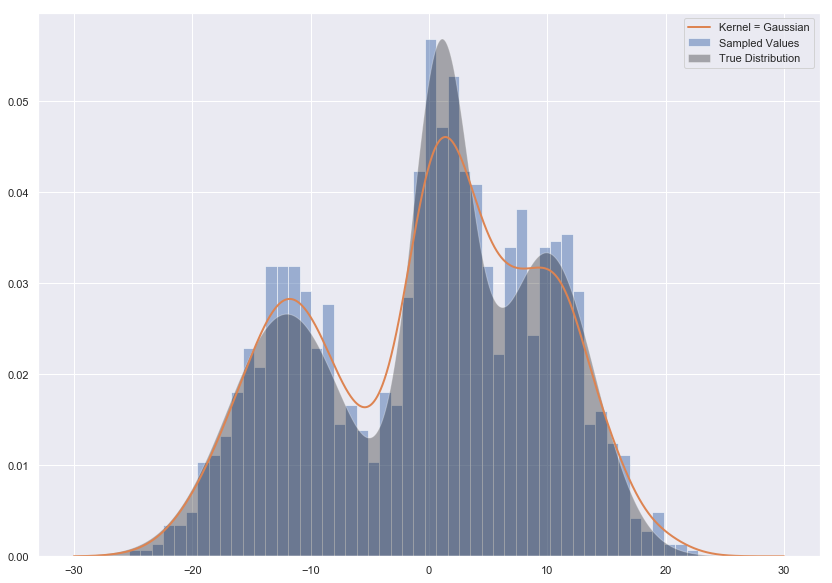

In [12]:
# histogram of random sample
# 1. true density
# 2. estimated density with optimal bandwidth

fig, ax = plt.subplots(figsize=(14, 10))

ax.hist(vals, bins=50, density=True, alpha=0.5, label='Sampled Values')
ax.fill(x_vec[:, 0], true_density, fc='black', alpha=0.3, label='True Distribution')

log_density = numpy.exp(grid.best_estimator_.score_samples(x_vec))
ax.plot(x_vec[:, 0], log_density, '-', linewidth=2, label='Kernel = Gaussian')

ax.legend(loc='upper right')

#### exercise 4: effect of kernel choice

In [13]:
# for plotting:
# (row of plot, column of plot, kernel function)

position_kernel_vec = [
    (0, 0, 'gaussian'), (0, 1, 'tophat'), 
    (1, 0, 'epanechnikov'), (1, 1, 'exponential'), 
    (2, 0, 'linear'), (2, 1, 'cosine'), 
]

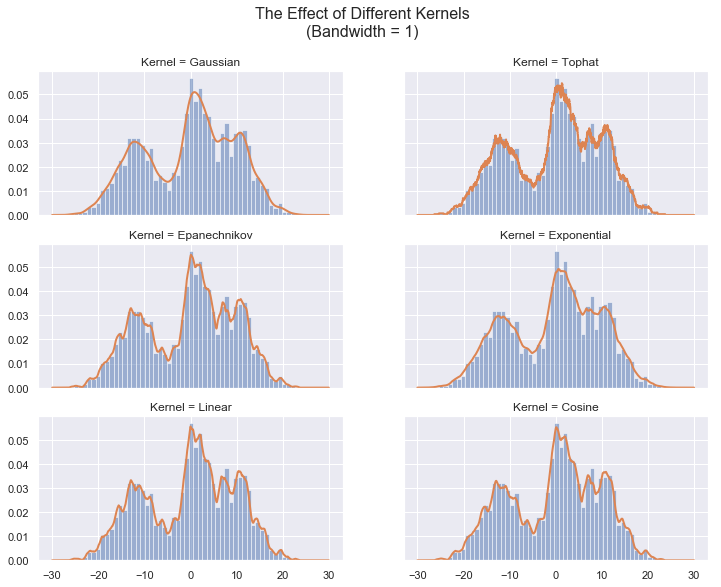

In [14]:
# effect of kernel function plot

fig, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(12, 9))
fig.suptitle('The Effect of Different Kernels\n(Bandwidth = 1)', fontsize=16)

for r, c, k in position_kernel_vec:
    kde = sklearn.neighbors.KernelDensity(kernel=k, bandwidth=1).fit(vals)
    log_density = kde.score_samples(x_vec)

    ax[r, c].hist(vals, bins=50, density=True, alpha=0.5)
    ax[r, c].plot(x_vec[:, 0], numpy.exp(log_density), '-', linewidth=2)
    ax[r, c].set_title('Kernel = {}'.format(k.capitalize()))

#### exercise 5: each point as a distribution

In [15]:
# function to evaluate the
# gaussian distribution

def eval_gaussian(x, m, b):
    numerator = numpy.exp(
        -numpy.power(x - m, 2) / (2 * numpy.power(b, 2))
    )
    denominator = b * numpy.sqrt(2 * numpy.pi)
    return numerator / denominator

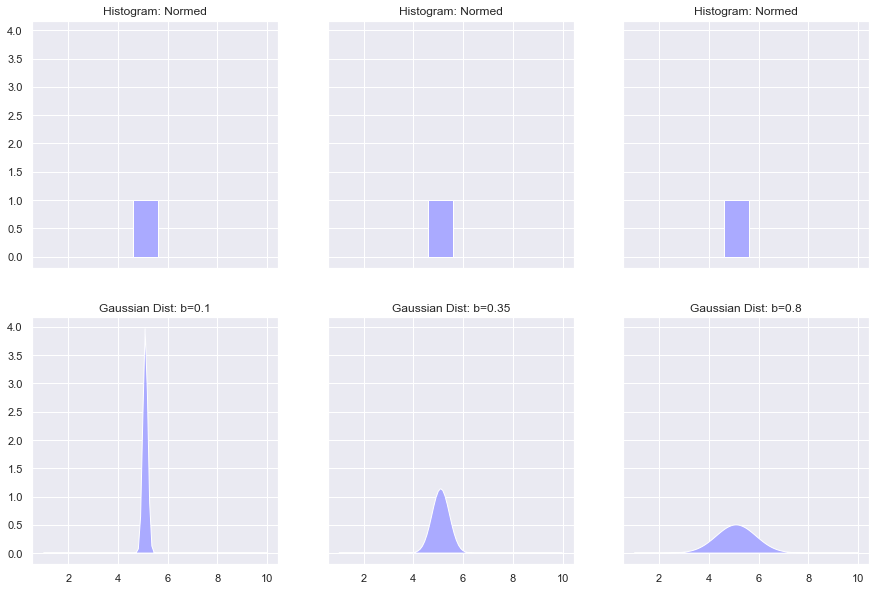

In [16]:
# plotting one point

m = numpy.array([5.1])
b_vec = [0.1, 0.35, 0.8]

x_vec = numpy.linspace(1, 10, 100)[:, None]

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15, 10))

for i, b in enumerate(b_vec):
    ax[0, i].hist(m[:], bins=1, fc='#AAAAFF', density=True)
    ax[0, i].set_title("Histogram: Normed")

    evaluation = eval_gaussian(x_vec, m=m[0], b=b)
    
    ax[1, i].fill(x_vec, evaluation, '-k', fc='#AAAAFF')
    ax[1, i].set_title("Gaussian Dist: b={}".format(b))

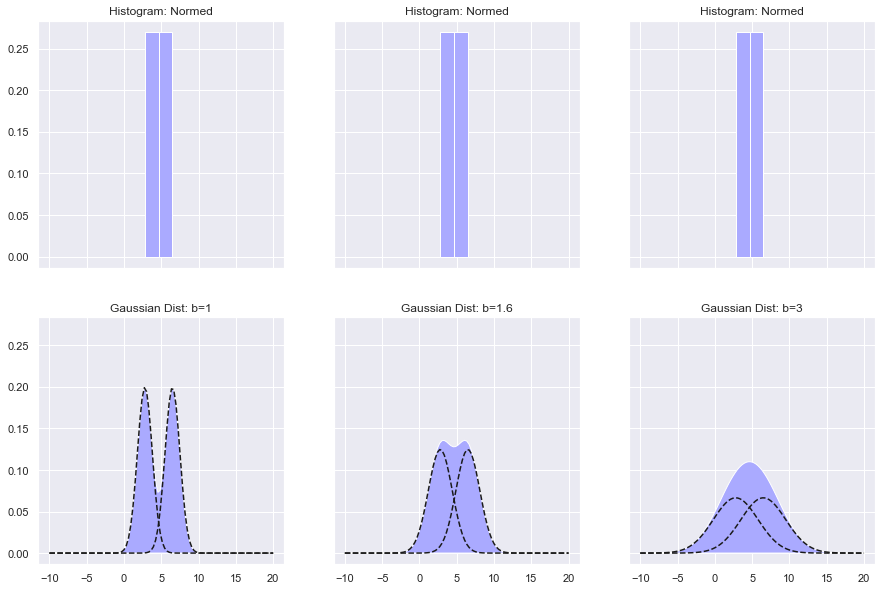

In [17]:
# plotting two points

m = numpy.array([2.8, 6.5])
b_vec = [1, 1.6, 3]

x_vec = numpy.linspace(-10, 20, 100)[:, None]

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15, 10))

for i, b in enumerate(b_vec):
    ax[0, i].hist(m[:], bins=2, fc='#AAAAFF', density=True)
    ax[0, i].set_title("Histogram: Normed")

    eval1 = eval_gaussian(x_vec, m=m[0], b=b) / 2
    eval2 = eval_gaussian(x_vec, m=m[1], b=b) / 2
    
    ax[1, i].fill(x_vec, eval1 + eval2, '-k', fc='#AAAAFF')
    ax[1, i].set_title("Gaussian Dist: b={}".format(b))
    ax[1, i].plot(x_vec, eval1, '-k', linestyle="dashed")
    ax[1, i].plot(x_vec, eval2, '-k', linestyle="dashed")

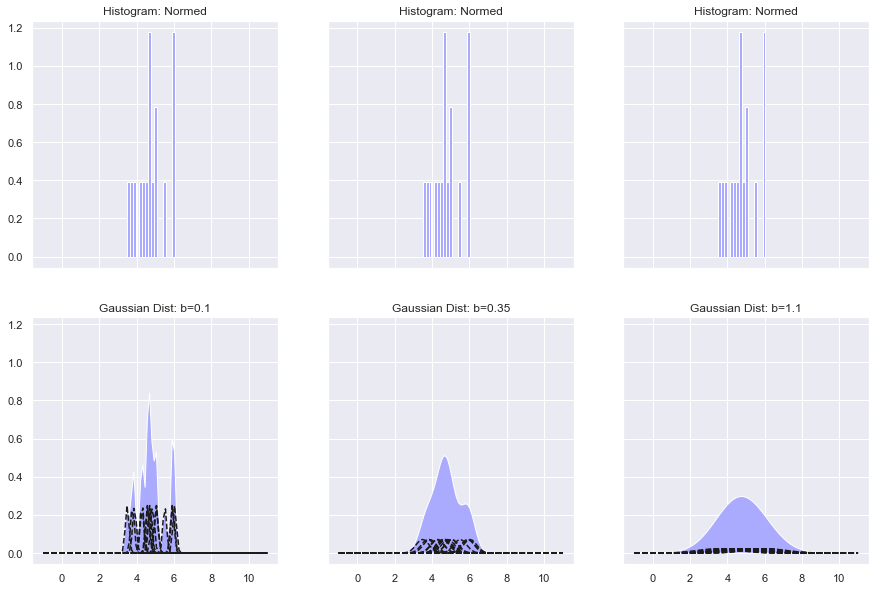

In [18]:
# plotting sixteen points

m = numpy.random.normal(4.7, 0.88, 16)
n = len(m)

b_vec = [0.1, 0.35, 1.1]

x_vec = numpy.linspace(-1, 11, 100)[:, None]

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15, 10))

for i, b in enumerate(b_vec):
    ax[0, i].hist(m[:], bins=n, fc='#AAAAFF', density=True)
    ax[0, i].set_title("Histogram: Normed")
        
    sum_evaluation = numpy.zeros(len(x_vec))
    
    for j in range(n):
        evaluation = eval_gaussian(x_vec, m=m[j], b=b) / n
        sum_evaluation += evaluation[:, 0]
        
        ax[1, i].plot(x_vec, evaluation, '-k', linestyle="dashed")

    ax[1, i].fill(x_vec, sum_evaluation, '-k', fc='#AAAAFF')
    ax[1, i].set_title("Gaussian Dist: b={}".format(b))

#### exercise 6: loading data and modeling with seaborn

In [19]:
# load california housing data

housing = sklearn.datasets.fetch_california_housing()

In [20]:
# turn housing data into pandas dataframe

df = pandas.DataFrame(housing['data'], columns=housing['feature_names'])
print("Dataframe Dimensions: {dims}".format(dims=df.shape))

Dataframe Dimensions: (20640, 8)


In [21]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [22]:
# median house age in block is less than or equal to 15 years

dfLess15 = df[df['HouseAge'] <= 15.0]
dfLess15 = dfLess15[['Latitude', 'Longitude']]
print(
    "Less Than Or Equal To 15 Years Dataframe Dimensions: {dims}"
    .format(dims=dfLess15.shape)
)

Less Than Or Equal To 15 Years Dataframe Dimensions: (3287, 2)


In [23]:
dfLess15.head()

,Latitude,Longitude
59,37.82,-122.29
87,37.81,-122.27
88,37.80,-122.27
391,37.90,-122.30
437,37.87,-122.30


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


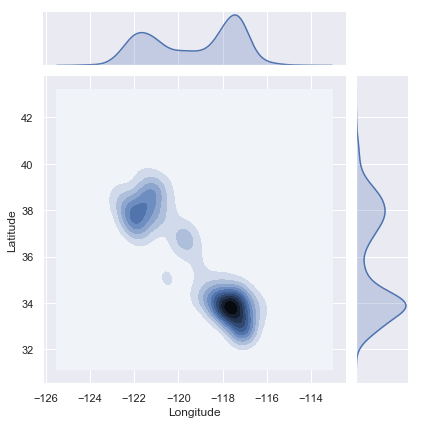

In [24]:
seaborn.jointplot("Longitude", "Latitude", dfLess15, kind="kde")

In [25]:
# median house age in block is more than 40 years

dfMore40 = df[df['HouseAge'] > 40.0]
dfMore40 = dfMore40[['Latitude', 'Longitude']]
print(
    "More Than 40 Years Dataframe Dimensions: {dims}"
    .format(dims=dfMore40.shape)
)

More Than 40 Years Dataframe Dimensions: (3878, 2)


In [26]:
dfMore40.head()

,Latitude,Longitude
0,37.88,-122.23
2,37.85,-122.24
3,37.85,-122.25
4,37.85,-122.25
5,37.85,-122.25


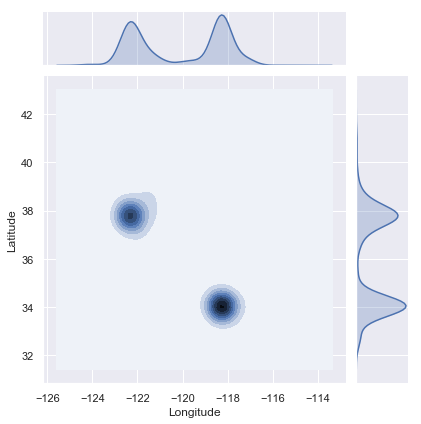

In [27]:
seaborn.jointplot("Longitude", "Latitude", dfMore40, kind="kde")

In [28]:
# perform filter
# plot non-location data

dfLess5 = df[df['HouseAge'] <= 5]

x_vals = dfLess5.Population.values
y_vals = dfLess5.MedInc.values

Text(0, 0.5, 'Median Income')

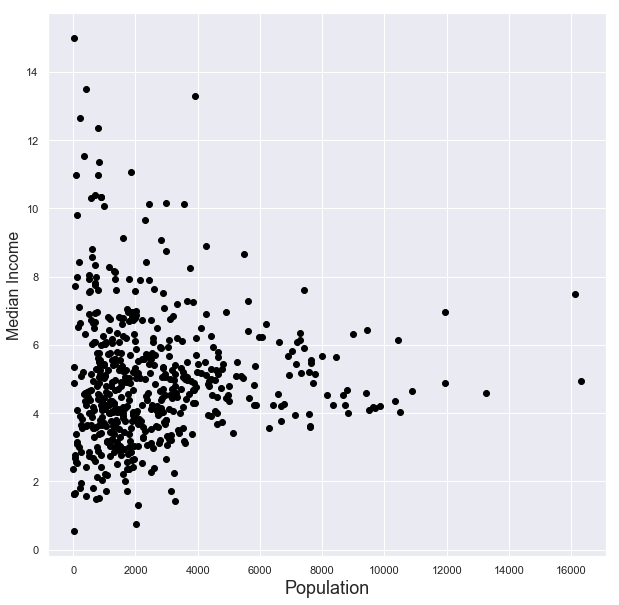

In [29]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(x_vals, y_vals, c='black')
plt.xlabel('Population', fontsize=18)
plt.ylabel('Median Income', fontsize=16)

Text(0.5, 1.0, 'Density Estimation With Scatterplot Overlay')

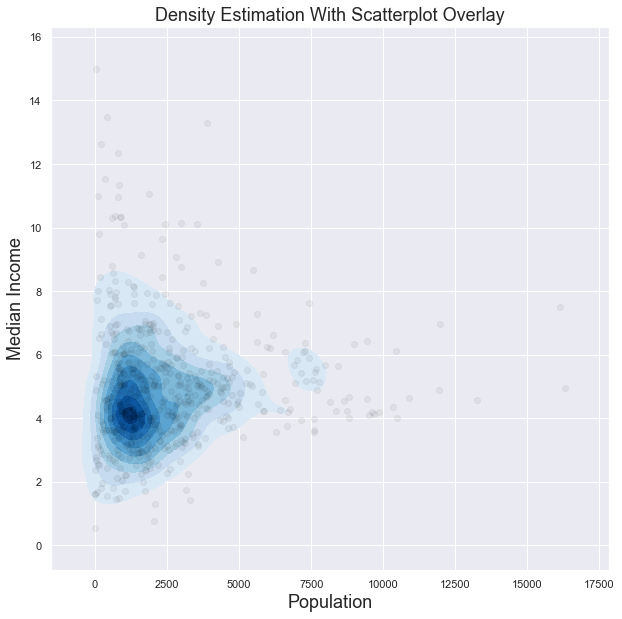

In [30]:
# run and visualize kernel density estimation
# on non-location data

fig = plt.figure(figsize=(10, 10))
ax = seaborn.kdeplot(
    x_vals, 
    y_vals,
    kernel='gau',
    cmap='Blues', 
    shade=True, 
    shade_lowest=False
)
plt.scatter(x_vals, y_vals, c='black', alpha=0.05)
plt.xlabel('Population', fontsize=18)
plt.ylabel('Median Income', fontsize=18)
plt.title('Density Estimation With Scatterplot Overlay', size=18)

#### exercise 7: sklearn and base maps

In [31]:
# set up the data grid for the contour plot

xgrid15 = numpy.sort(list(dfLess15['Longitude']))
ygrid15 = numpy.sort(list(dfLess15['Latitude']))
x15, y15 = numpy.meshgrid(xgrid15, ygrid15)
print("X Grid Component:\n{}\n".format(x15))
print("Y Grid Component:\n{}\n".format(y15))

X Grid Component:
[[-124.23 -124.19 -124.17 ... -114.63 -114.57 -114.31]
 [-124.23 -124.19 -124.17 ... -114.63 -114.57 -114.31]
 [-124.23 -124.19 -124.17 ... -114.63 -114.57 -114.31]
 ...
 [-124.23 -124.19 -124.17 ... -114.63 -114.57 -114.31]
 [-124.23 -124.19 -124.17 ... -114.63 -114.57 -114.31]
 [-124.23 -124.19 -124.17 ... -114.63 -114.57 -114.31]]

Y Grid Component:
[[32.54 32.54 32.54 ... 32.54 32.54 32.54]
 [32.55 32.55 32.55 ... 32.55 32.55 32.55]
 [32.55 32.55 32.55 ... 32.55 32.55 32.55]
 ...
 [41.74 41.74 41.74 ... 41.74 41.74 41.74]
 [41.75 41.75 41.75 ... 41.75 41.75 41.75]
 [41.78 41.78 41.78 ... 41.78 41.78 41.78]]



In [32]:
# combine x and y grids into pairs
# this is like the x_vec above

xy15 = numpy.vstack([y15.ravel(), x15.ravel()]).T
print("Grid:\n{}\n".format(xy15))

Grid:
[[  32.54 -124.23]
 [  32.54 -124.19]
 [  32.54 -124.17]
 ...
 [  41.78 -114.63]
 [  41.78 -114.57]
 [  41.78 -114.31]]



In [33]:
# run kernel density estimation

print("Computing KDE.")

kde = sklearn.neighbors.KernelDensity(
    bandwidth=0.05, 
    metric='minkowski',
    kernel='gaussian', 
    algorithm='ball_tree'
)
kde.fit(dfLess15.values)

Computing KDE.


KernelDensity(algorithm='ball_tree', atol=0, bandwidth=0.05,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='minkowski', metric_params=None, rtol=0)

In [34]:
# fit the trained model on the xy grid

log_density = kde.score_samples(xy15)
density = numpy.exp(log_density)
density = density.reshape(x15.shape)
print("Shape of Density Values:\n{}\n".format(density.shape))

Shape of Density Values:
(3287, 3287)



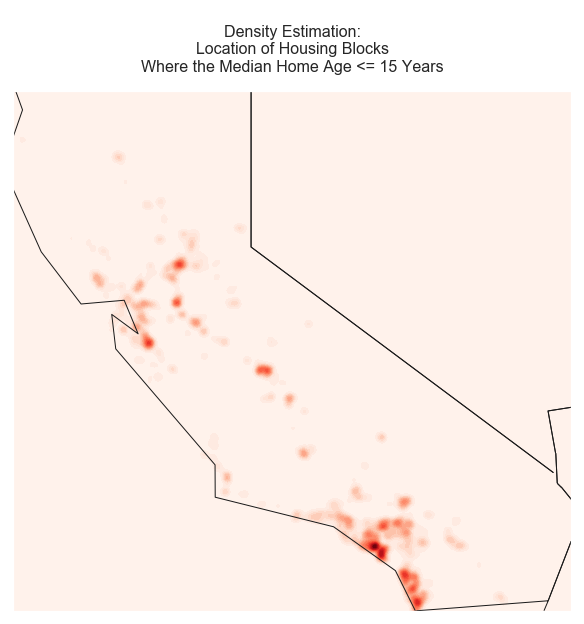

In [36]:
# visualize the results

fig = plt.figure(figsize=(10, 10))
fig.suptitle(
    """
    Density Estimation:
    Location of Housing Blocks
    Where the Median Home Age <= 15 Years
    """, 
    fontsize=16
)

the_map = mpl_toolkits.basemap.Basemap(
    projection='cyl',
    llcrnrlat=y15.min(), urcrnrlat=y15.max(),
    llcrnrlon=x15.min(),urcrnrlon=x15.max(),
    resolution='c'
)

the_map.drawcoastlines(linewidth=1)
the_map.drawcountries(linewidth=1)
the_map.drawstates(linewidth=1)

levels = numpy.linspace(0, density.max(), 25)
plt.contourf(x15, y15, density, levels=levels, cmap=plt.cm.Reds)

plt.show()

In [37]:
# set up the data grid for the contour plot

xgrid40 = numpy.sort(list(dfMore40['Longitude']))
ygrid40 = numpy.sort(list(dfMore40['Latitude']))
x40, y40 = numpy.meshgrid(xgrid40, ygrid40)
print("X Grid Component:\n{}\n".format(x40))
print("Y Grid Component:\n{}\n".format(y40))

X Grid Component:
[[-124.35 -124.26 -124.23 ... -114.61 -114.6  -114.59]
 [-124.35 -124.26 -124.23 ... -114.61 -114.6  -114.59]
 [-124.35 -124.26 -124.23 ... -114.61 -114.6  -114.59]
 ...
 [-124.35 -124.26 -124.23 ... -114.61 -114.6  -114.59]
 [-124.35 -124.26 -124.23 ... -114.61 -114.6  -114.59]
 [-124.35 -124.26 -124.23 ... -114.61 -114.6  -114.59]]

Y Grid Component:
[[32.64 32.64 32.64 ... 32.64 32.64 32.64]
 [32.66 32.66 32.66 ... 32.66 32.66 32.66]
 [32.66 32.66 32.66 ... 32.66 32.66 32.66]
 ...
 [41.43 41.43 41.43 ... 41.43 41.43 41.43]
 [41.73 41.73 41.73 ... 41.73 41.73 41.73]
 [41.78 41.78 41.78 ... 41.78 41.78 41.78]]



In [38]:
# combine x and y grids into pairs
# this is like the x_vec above

xy40 = numpy.vstack([y40.ravel(), x40.ravel()]).T
print("Grid:\n{}\n".format(xy40))

Grid:
[[  32.64 -124.35]
 [  32.64 -124.26]
 [  32.64 -124.23]
 ...
 [  41.78 -114.61]
 [  41.78 -114.6 ]
 [  41.78 -114.59]]



In [39]:
# run kernel density estimation

print("Computing KDE.")

kde = sklearn.neighbors.KernelDensity(
    bandwidth=0.05, 
    metric='minkowski',
    kernel='gaussian', 
    algorithm='ball_tree'
)
kde.fit(dfMore40.values)

Computing KDE.


KernelDensity(algorithm='ball_tree', atol=0, bandwidth=0.05,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='minkowski', metric_params=None, rtol=0)

In [40]:
# fit the trained model on the xy grid

log_density = kde.score_samples(xy40)
density = numpy.exp(log_density)
density = density.reshape(x40.shape)
print("Shape of Density Values:\n{}\n".format(density.shape))

Shape of Density Values:
(3878, 3878)



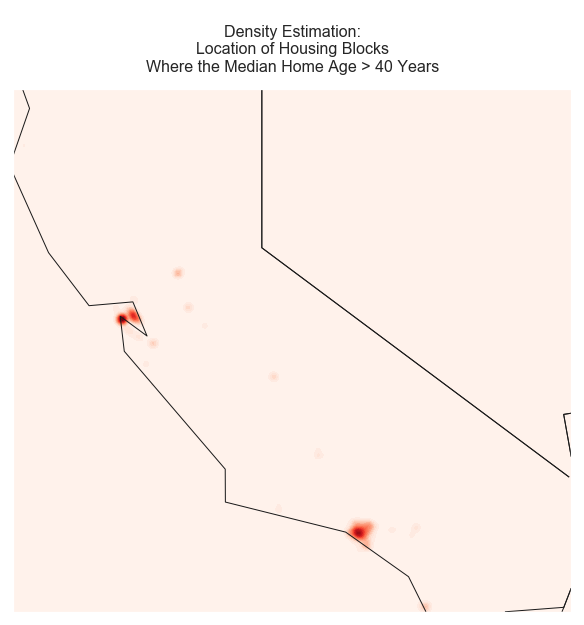

In [41]:
# visualize the results

fig = plt.figure(figsize=(10, 10))
fig.suptitle(
    """
    Density Estimation:
    Location of Housing Blocks
    Where the Median Home Age > 40 Years
    """, 
    fontsize=16
)

the_map = mpl_toolkits.basemap.Basemap(
    projection='cyl',
    llcrnrlat=y40.min(), urcrnrlat=y40.max(),
    llcrnrlon=x40.min(),urcrnrlon=x40.max(),
    resolution='c'
)

the_map.drawcoastlines(linewidth=1)
the_map.drawcountries(linewidth=1)
the_map.drawstates(linewidth=1)

levels = numpy.linspace(0, density.max(), 25)
plt.contourf(x40, y40, density, levels=levels, cmap=plt.cm.Reds)

plt.show()